In [277]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/10/09 16:19
# @Author  : Wang Yujia
# @File    : SA_for_PT_model.ipynb
# @Description : Parameter estimation for PT_model using Simulated Annealing

# 0. What for

# 1. Preparations
1. infer参数一是需要data，二是需要把p表示出来才能写出来loss func
2. data来自`data_selected_path`

## 1.1 全局设置
1. 除了表示uniq auction的features，还引入了
    - 'cnt_uniq':表示paper里的Loss function公式里的A

In [279]:
# data path
data_selected_path = "../data/info_asymm/datawithnp_asc_symmetry_2_selected.csv"
# data_key path
data_key_path = "../data/SA_PT/data_key.csv"
# optimized parameters' saving path:
params_opitim_path = "../data/SA_PT/params_opitim.csv"

# for PT
# alpha = 1
# delta = 1
# labda = 2.25
# features that GT need
features_GT = ['product_id','bidincrement','bidfee','retail']
features_GT_infer = ['cnt_uniq']

# for SA
# initial params
table_5_M = [0.025,0.85,3.72]
# lower/ upper bound
lb = [-0.3,0.01,0.01]
ub = [0.3, 3, 18]


import numpy as np
import pandas as pd
import sympy
import seaborn as sns
from tqdm.notebook import tqdm
from sko.SA import SABoltzmann
import matplotlib.pyplot as plt
import datetime
from sko.tools import set_run_mode
from scipy.optimize import fsolve
from visdom import Visdom

viz = Visdom()

Setting up a new session...


## 1.2 data 读取
1. 读取data以做SA
2. 提取出来`data_key`，以及其他计算需要的features

In [280]:
data = pd.read_csv(data_selected_path, encoding="utf-8")
data_key = data[features_GT].copy()
data_key.drop_duplicates(inplace=True)
data_key.to_csv(data_key_path,header=True, encoding="utf-8",index=False)

B = np.array(data.bidfee)               # bid fee (cent to dollar)
D = np.array(data.bidincrement)         # bid increment (cent to dollar)
V = np.array(data.retail)               # valuation
# 需要计算`N_uniq_auction`组setting下的结果
N_uniq_auction= data_key.shape[0]

print("For PT model, there are *{}* settings waiting to be inferred.".format(N_uniq_auction))

For PT model, there are *1303* settings waiting to be inferred.


## 1.3 functions about 'key'

In [281]:
# get key from i in 'data_key'
def get_key_from_index(i,str="NotStr"):
    if(str=="str"):
        key_i = list(data_key.iloc[i,:])
        key_i_str = (str(key_i[0]),str(key_i[1]),str(key_i[2]))
        return key_i_str
    else:
        key_i = data_key.iloc[i,:]
        return key_i

#features_GT = ['product_id','bidincrement','bidfee','retail']
def select_data_fromkey(key_i_str):
    return data[(data['product_id'] == key_i_str[0]) & (data['bidincrement'] == key_i_str[1]) & (data['bidfee'] == key_i_str[2]) & (data['retail'] == key_i_str[3])].copy()


# 2. PT model
## 2.1 prob. weighting func
1. 根据Eq(5)

In [282]:
def OMEGA(p,delta):
    # return p**delta * ((p**delta + (1-p)**delta)**(-1/delta))
    return p

## 2.2 C_{t-1}
1. 根据5.1.2

In [283]:
def C(t,b):
    return 0.2*t*b

## 2.3 value functions
1. 根据Eq(7)-(9)
2. 注意这里把(-labda)(1-sympy.E**(alpha*x))/alpha的`labda`拿到外面去了，方便写

In [284]:
# valuation function
def f(x, alpha):
    # return (1-x**alpha)
    return (1-sympy.E**(-alpha*x))
    # return (1-np.exp(-alpha*x))

## 2.4 Equi. condition
1. 根据Eq(6)
2. 注意分辨怎么代入上面的公式

In [285]:
ans_scipy=[]
def func_1(u,*args):
    alpha,delta,labda,t,b,tmp = args
    return (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))

def func_2(u,*args):
    alpha,delta,labda,t,b,tmp = args
    return (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))

def f_Equi(t,v,d,b,alpha,labda,delta):
    u = sympy.Symbol('u')

    tmp = v-d*t-C(t-1,b) - b

    if(tmp >= 0):
        func_1 = (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))
        root =  sympy.nsolve(func_1,(0,1),solver='bisect', verify=False)
        #print(f"t:{t} ---- u:{root}")
    else:
        func_2 = (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))
        root =  sympy.nsolve(func_2,(0,1),solver='bisect', verify=False)
        #print(f"t:{t} -- u:{root}")

    # if(tmp >= 0):
    #     root = fsolve(func_1,np.zeros(1),args =(alpha,delta,labda,t,b,tmp))
    #     if(root == 0.0):
    #         print(f"t:{t} ---- u:{root}")
    # else:
    #     root = fsolve(func_2,np.zeros(1),args =(alpha,delta,labda,t,b,tmp))
    #     if(root == 0.0):
    #         print(f"t:{t} -- u:{root}")
    return root

# 3. SA
## 3.1 define loss function
1. loss function: NLL for auctions with same `features_GT`
2.

In [286]:
def loss_func(params):
    #start_time_loss = datetime.datetime.now()
    alpha = params[0]
    delta = params[1]
    labda = params[2]

    # solve for U from Equi. condt.
    U_i = [0] * (max_T + 1)
    U_i[0] = 1

    for t in range(1,max_T+1):

        U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)
        #viz.line([0.0],[0],win = 'U_i_'+str(i),opts= dict(title='U_i[t]'))
        #viz.line([np.float(U_i[t])],[t],win = 'U_i_'+str(i), update='append')

    # calculate NLL under this auction setting & PT params
    nll = 0.0
    if(U_i[0]==1):
        U_i.pop(0)            # because U_i[0]=1
    U_tmp_df = pd.DataFrame(U_i, index=np.arange(0, U_i.__len__()), columns=['U'], dtype=float)
    for idx in range(0,data_i.shape[0]):
        # sum up the log prob among all durations of this auction
        nll += ( np.sum(U_tmp_df[0:(T_i[idx]-1)][:].apply(np.log,axis=1)) + np.log(1-U_tmp_df.iat[(T_i[idx]-1),0]) )* cnt_n_2_i[idx]
    #print('> The loss costs {time_costs}s \n'.format(time_costs=(datetime.datetime.now() - start_time_loss).total_seconds()))

    return float(-nll)

## 3.2 do SA
1. 要对每一个setting做一次infer == 对每一个setting执行一次SA。
    - 可以并行吗？YES
2. 具体的：对每个setting `i`
    - 每一个setting `i` 可以提取出来一个`data_i`，代表所有auction
    - 每一个`data_i`中的`cnt_uniq`，也就是`A`，是相同的，表示setting `i` 进行的拍卖总次数.【但是这个`A`在计算loss的时候派不上用场】
    - `N`表示duration，因此paper公式里的$T_a$即`N[a]`
    - 因此有`A = sum(data_i['cnt_n_2'])`，其中的'cnt_n_2'表示了该行对应的`duration=N`发生的次数
    - 按照上文，求解`U[i]_t` which is a array with shape of (max(N)),也就是求解paper里的`p_t`
    - 求nll时，记得
3.每次进行`L`次对参数的试探寻找，每次寻找对应一个温度一组新的参数。
    - 优化的完成/退出条件：温度小于`T_min`或者最低温度保持`max_stay_counter`次的不变
    - 鉴于温度小于`T_min`很难达到，因此基本上对一组参数进行优化要进行L*max_stay_counter+1次运算（loss运算）

In [287]:
params_opitim = pd.DataFrame(columns=['key_idx','alpha','delta','labda','initial_loss','final_loss','avg_loss'])

<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-288-0b16f4f810d5>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(A_i == sum(cnt_n_2_i),"'cnt_uniq' does not match with sum of 'cnt_n_2'!")


> For the 3th data_key, there is:
> retail = 89.99,bidincrement = 0.15, bidfee = 0.75, infer PT's parameters
> Initilizing SA....... 

> Now do SA....... 

STOP CODE:  Stay unchanged in the last 11 iterations
> The whole inference process costs 591.253103s 

> SA ENDS....... 

> For the 4th data_key, there is:
> retail = 59.99,bidincrement = 0.15, bidfee = 0.75, infer PT's parameters
> Initilizing SA....... 

> Now do SA....... 

STOP CODE:  Stay unchanged in the last 11 iterations
> The whole inference process costs 213.174299s 

> SA ENDS....... 



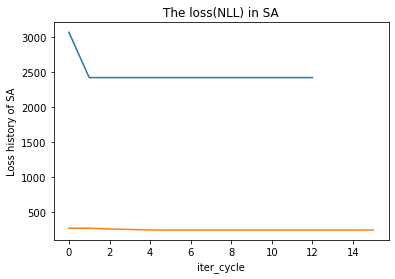

In [288]:
# Perform SA respectively for all settings
# for i in range(0,N_uniq_auction):
for i in range(5,8):
    start_time = datetime.datetime.now()

    # get i_th data_key
    key_i = get_key_from_index(i)
    # extract data with same `key_i` into a table
    data_i = select_data_fromkey(key_i)
    data_i.reset_index(drop=True,inplace=True)

    T_i = data_i['N'].astype(int)          # auction duration sequence
    max_T = int(max(T_i))                  # max duration value

    cnt_n_2_i = data_i['cnt_n_2'].astype(int)       # Number of occurrences of different durations
    # for a certain auction(like 'data_i'), 'cnt_uniq' should be all the same
    A_i = int(data_i['cnt_uniq'].unique())
    assert(A_i == sum(cnt_n_2_i),"'cnt_uniq' does not match with sum of 'cnt_n_2'!")

    v = float(data_i['retail'].unique())
    d = float(data_i['bidincrement'].unique())
    b = float(data_i['bidfee'].unique())

    # calculate NLL
    print("> For the {}th data_key, there is:".format(i))
    print("> retail = {0},bidincrement = {1}, bidfee = {2}, infer PT's parameters".format(v,d,b))
    print("> Initilizing SA....... \n")
    # L=50, max_stay_counter=50
    set_run_mode(loss_func, 'cached')
    set_run_mode(loss_func, 'multithreading')
    # T_max = round(v)或者 T_max = (v-d)/b
    sa_boltzmann = SABoltzmann(func=loss_func, x0=table_5_M, T_max=round((v-d)/b), T_min=1, learn_rate=0.3, L=20, max_stay_counter=10,
                            lb=lb, ub=ub)

    print("> Now do SA....... \n")
    best_x, best_y = sa_boltzmann.run()
    print('> The whole inference process costs {time_costs}s \n'.format(time_costs=(datetime.datetime.now() - start_time).total_seconds()))

    print("> SA ENDS....... \n")

    # draw the pic of NLL Loss in SA
    viz.line([0.0]*(sa_boltzmann.iter_cycle+1),[0]*(sa_boltzmann.iter_cycle+1),win = 'Loss trial',opts= dict(title='The loss trial'))
    viz.line(np.array(sa_boltzmann.generation_best_Y),np.arange(0,sa_boltzmann.iter_cycle+1),win = 'Loss trial', update='append')

    # dicard plt drawing since visdom is better
    # plt.title("The loss(NLL) in SA".format(i,N_uniq_auction))
    # plt.xlabel("iter_cycle")
    # plt.ylabel("Loss history of SA")
    # sns.lineplot(x = np.arange(0,sa_boltzmann.iter_cycle+1),y=np.array(sa_boltzmann.generation_best_Y))

    # append the opitimized params into the df
    df_tmp = pd.DataFrame([[i,best_x[0],best_x[1],best_x[2],sa_boltzmann.generation_best_Y[0],best_y,best_y/A_i]],columns=['key_idx','alpha','delta','labda','initial_loss','final_loss','avg_loss'])
    params_opitim = params_opitim.append(df_tmp,ignore_index=True)  # ignore_index=True could help in rearranging index

# save inference results
params_opitim.to_csv(params_opitim_path, header=True, encoding="utf-8",index=False)

# 4 P
1. 得到`params_opitim`之后，可以对不同的auction settings做generate了
2. generate过程无非是求u-->p，u的代码在上面loss func里写过了。然后把P存到dict里

In [ ]:
# solve for U&P respectively for all settings
P = {}
for i in range(0,N_uniq_auction):

    # get optimized params
    alpha, labda, delta = params_opitim.iloc[i][0],params_opitim.iloc[i][1],params_opitim.iloc[i][2]

    # get i_th data_key
    key_i = get_key_from_index(i)
    # extract data with same `key_i` into a table
    data_i = select_data_fromkey(key_i)
    data_i.reset_index(drop=True,inplace=True)

    T_i = data_i['N'].astype(int)          # auction duration sequence
    max_T = int(max(T_i))                  # max duration value

    cnt_n_2_i = data_i['cnt_n_2'].astype(int)       # Number of occurrences of different durations

    v = float(data_i['retail'].unique())
    d = float(data_i['bidincrement'].unique())
    b = float(data_i['bidfee'].unique())

    U_i = [0] * (max_T + 1)
    U_i[0] = 1
    key_i_str = get_key_from_index
    P[key_i_str] = np.array([0.0]*(max_T+1))
    P_tmp = [0.0]*(max_T+1)   # P is what we want to generate
    P_tmp[0] = 1
    tmp2 = 1

    # solve for U
    for t in range(1,max_T+1):
        U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)
        P_tmp[t] = (1- U_i[t])*tmp2
        tmp2 = tmp2*U_i[t]
    # solve for P
    # for j in range()
    # # P[key_i][j] = 1.0-b[i]/(v[i]-s[i]*(j-1))